<H1>Ensembling Experiment</H1>

In [58]:
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt

import dsbhelper as dsb
import nuclei
import model as modellib
import dsbhelper

In [59]:
TRAIN_DATA = 'stage1_train'
gcs_model_weights = 'trained_models/model_b12eb9/mask_rcnn.h5'
ws_model_weights = 'trained_models/model_39743d/mask_rcnn.h5'
rw_model_weights = 'trained_models/model_70ffa5/mask_rcnn.h5'
ag_model_weights = 'trained_models/model_c4f686/mask_rcnn.h5'
am_model_weights = 'trained_models/model_3f138a/mask_rcnn.h5'

In [60]:
# configure the trainer for inference
config = nuclei.InferenceConfig()


In [61]:
# set up the dataset and load validate data
dataset_val = nuclei.NucleiDataset()
dataset_val.load_data(TRAIN_DATA, mode='validate', filter_ids=dsb.validation_set)
dataset_val.prepare()


In [62]:
# load the model
local_model_folder = 'model'
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=local_model_folder)


In [63]:
# get the link between image_id and specimen_id
for image_id in dataset_val.image_ids:
    image_data = dataset_val.get_info(image_id)
    print ('{} -> {}'.format(image_id, image_data['specimen_id']))

0 -> 003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
1 -> 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
2 -> 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf
3 -> 04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e
4 -> 0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275
5 -> 08ae2741df2f5ac815c0f272a8c532b5167ee853be9b939b9b8b7fa93560868a
6 -> 091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d
7 -> 0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
8 -> 0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe
9 -> 0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
10 -> 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
11 -> 0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
12 -> 0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
13 -> 1023509cf8d4c155467800f89508690be9513431992f470594281cd37dbd020d
14 -> 12f89395ad

In [64]:
# pick a specimen
#image_id = random.choice(dataset_val.image_ids)
image_id = 56
image_data = dataset_val.get_info(image_id)
print(image_data['specimen_id'])

6aa7dd0c88bec4f96cdd497f9c37779733033d9ec6513307461302d36bd32ac7


<H2>Ground Truth</H2>
Ground truth from the original masks.

In [65]:
# get ground truth data
original_image, _, \
class_ids, \
rois,\
gt_masks = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)

In [66]:
print(gt_masks.shape[-1])

10


<H3>Base Model</H3>

In [67]:
# remove previous model
!rm model/mask_rcnn.h5

In [68]:
# load original prediction weights
model.load_weights(dsbhelper.get_pretrained_weights(pretrained='last',
                                                    gcs_weights_fname=gcs_model_weights), by_name=True)

In [69]:
# get predictions
p = model.detect([original_image], verbose=1)
prediction = p[0]
print(prediction['masks'].shape)
print(prediction['rois'].shape)
print(prediction['scores'].shape)
print(prediction['class_ids'].shape)

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  253.00000
molded_images            shape: (1, 512, 512, 3)      min:  -36.82168  max:  214.78432
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 10)
(10, 4)
(10,)
(10,)


In [70]:
# drop small masks from the prediction
prediction['masks'], \
    prediction['rois'], \
    prediction['class_ids'], \
    prediction['scores'] = dsbhelper.drop_small_masks(prediction['masks'], 
                                                      prediction['rois'], 
                                                      prediction['class_ids'], 
                                                      prediction['scores'], 
                                                      min=0.15,
                                                      max=6.0)

In [79]:
print(prediction['masks'].shape)

(512, 512, 10)


<H3>Watershed Annotation Model</H3>

In [71]:
# remove previous model
!rm model/mask_rcnn.h5

In [72]:
# load watershed annotation weights
model.load_weights(dsbhelper.get_pretrained_weights(pretrained='last',
                                                    gcs_weights_fname=ws_model_weights), by_name=True)

In [73]:
# get watershed predictions
ws_p = model.detect([original_image], verbose=1)
ws_prediction = ws_p[0]
print(ws_prediction['masks'].shape)
print(ws_prediction['rois'].shape)
print(ws_prediction['scores'].shape)
print(ws_prediction['class_ids'].shape)

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  253.00000
molded_images            shape: (1, 512, 512, 3)      min:  -36.82168  max:  214.78432
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 10)
(10, 4)
(10,)
(10,)


In [17]:
# drop small masks
ws_prediction['masks'], \
    ws_prediction['rois'], \
    ws_prediction['class_ids'], \
    ws_prediction['scores'] = dsbhelper.drop_small_masks(ws_prediction['masks'], 
                                                         ws_prediction['rois'], 
                                                         ws_prediction['class_ids'], 
                                                         ws_prediction['scores'], 
                                                         min=0.15,
                                                         max=6.0)

<H3>Random Walk Annotation Model</H3>

In [18]:
# remove previous model
!rm model/mask_rcnn.h5

In [19]:
# load random walk annotation weights
model.load_weights(dsbhelper.get_pretrained_weights(pretrained='last',
                                                    gcs_weights_fname=rw_model_weights), by_name=True)

In [20]:
# get random walk predictions
rw_p = model.detect([original_image], verbose=1)
rw_prediction = rw_p[0]
print(rw_prediction['masks'].shape)
print(rw_prediction['rois'].shape)
print(rw_prediction['scores'].shape)
print(rw_prediction['class_ids'].shape)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000
molded_images            shape: (1, 512, 512, 3)      min:  -46.82168  max:  197.82254
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 79)
(79, 4)
(79,)
(79,)


In [21]:
# drop small masks
rw_prediction['masks'], \
    rw_prediction['rois'], \
    rw_prediction['class_ids'], \
    rw_prediction['scores'] = dsbhelper.drop_small_masks(rw_prediction['masks'], 
                                                         rw_prediction['rois'], 
                                                         rw_prediction['class_ids'], 
                                                         rw_prediction['scores'], 
                                                         min=0.15,
                                                         max=6.0)

<H3>Active Contours with Gaussian Blur Annotation Model</H3>

In [22]:
# remove previous model
!rm model/mask_rcnn.h5

In [23]:
# load active contours gaussian annotation weights
model.load_weights(dsbhelper.get_pretrained_weights(pretrained='last',
                                                    gcs_weights_fname=ag_model_weights), by_name=True)

In [24]:
# get active contours gaussian predictions
ag_p = model.detect([original_image], verbose=1)
ag_prediction = ag_p[0]
print(ag_prediction['masks'].shape)
print(ag_prediction['rois'].shape)
print(ag_prediction['scores'].shape)
print(ag_prediction['class_ids'].shape)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000
molded_images            shape: (1, 512, 512, 3)      min:  -46.82168  max:  197.82254
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 73)
(73, 4)
(73,)
(73,)


In [25]:
# drop small masks
ag_prediction['masks'], \
    ag_prediction['rois'], \
    ag_prediction['class_ids'], \
    ag_prediction['scores'] = dsbhelper.drop_small_masks(ag_prediction['masks'], 
                                                         ag_prediction['rois'], 
                                                         ag_prediction['class_ids'], 
                                                         ag_prediction['scores'], 
                                                         min=0.15,
                                                         max=6.0)

<H3>Active Contours with Median Blur Annotation Model</H3>

In [26]:
# remove previous model
!rm model/mask_rcnn.h5

In [27]:
# load active contours median annotation weights
model.load_weights(dsbhelper.get_pretrained_weights(pretrained='last',
                                                    gcs_weights_fname=am_model_weights), by_name=True)

In [28]:
# get active contours median predictions
am_p = model.detect([original_image], verbose=1)
am_prediction = am_p[0]
print(am_prediction['masks'].shape)
print(am_prediction['rois'].shape)
print(am_prediction['scores'].shape)
print(am_prediction['class_ids'].shape)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000
molded_images            shape: (1, 512, 512, 3)      min:  -46.82168  max:  197.82254
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 80)
(80, 4)
(80,)
(80,)


In [29]:
# drop small masks
am_prediction['masks'], \
    am_prediction['rois'], \
    am_prediction['class_ids'], \
    am_prediction['scores'] = dsbhelper.drop_small_masks(am_prediction['masks'], 
                                                         am_prediction['rois'], 
                                                         am_prediction['class_ids'], 
                                                         am_prediction['scores'], 
                                                         min=0.15,
                                                         max=6.0)

In [30]:
# ----------------------------------------------------------------
# Calculates the intersection over union of two bounding boxes
# ----------------------------------------------------------------
def bbox_iou(boxA, boxB):
    
    # y1, x1, y2, x2
    if not (boxA[3] < boxB[1] or boxB[3] < boxA[1] or boxA[0] > boxB[2] or boxB[0] > boxA[2]):  
    
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[1], boxB[1])
        yA = max(boxA[0], boxB[0])
        xB = min(boxA[3], boxB[3])
        yB = min(boxA[2], boxB[2])

        # compute the area of intersection rectangle
        interArea = np.abs((xB - xA + 1) * (yB - yA + 1))

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = np.abs((boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1))
        boxBArea = np.abs((boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1))

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
    
    else:
        
        iou = 0
 
    # return the intersection over union value
    return iou

In [31]:
# ----------------------------------------------------------------------
# Calculates the per pixel intersection over union of two binary masks
# ----------------------------------------------------------------------
def pixel_iou(m1, m2):
    intersection = m1 * m2
    union = m1 | m2
    return (np.sum(intersection)/np.sum(union)).astype(np.float16)

In [32]:
for i, bb_a in enumerate(prediction['rois']):
    for j, bb_b in enumerate(ag_prediction['rois']):
        iou = bbox_iou(bb_a, bb_b)
        if iou > 0.5 and iou <= 1:
            pix_iou = pixel_iou(prediction['masks'][:,:,i], ag_prediction['masks'][:,:,j])
            print('pd[{:02d}][p={:0.3f}]:ag[{:02d}][p={:0.3f}] -> pix_iou={:0.3f}'.format(i, 
                                                                                          prediction['scores'][i], 
                                                                                          j, 
                                                                                          ag_prediction['scores'][j], 
                                                                                          pix_iou))


pd[00][p=1.000]:ag[25][p=0.992] -> pix_iou=0.802
pd[01][p=1.000]:ag[01][p=0.998] -> pix_iou=0.816
pd[02][p=1.000]:ag[13][p=0.996] -> pix_iou=0.776
pd[03][p=1.000]:ag[24][p=0.994] -> pix_iou=0.794
pd[04][p=1.000]:ag[42][p=0.980] -> pix_iou=0.772
pd[05][p=1.000]:ag[03][p=0.998] -> pix_iou=0.799
pd[06][p=1.000]:ag[06][p=0.997] -> pix_iou=0.860
pd[07][p=1.000]:ag[48][p=0.962] -> pix_iou=0.748
pd[08][p=0.999]:ag[53][p=0.937] -> pix_iou=0.688
pd[09][p=0.999]:ag[17][p=0.995] -> pix_iou=0.779
pd[10][p=0.999]:ag[05][p=0.997] -> pix_iou=0.780
pd[11][p=0.999]:ag[04][p=0.998] -> pix_iou=0.839
pd[12][p=0.999]:ag[23][p=0.994] -> pix_iou=0.714
pd[13][p=0.999]:ag[09][p=0.997] -> pix_iou=0.837
pd[14][p=0.999]:ag[14][p=0.996] -> pix_iou=0.700
pd[15][p=0.999]:ag[21][p=0.995] -> pix_iou=0.877
pd[16][p=0.999]:ag[07][p=0.997] -> pix_iou=0.792
pd[17][p=0.999]:ag[16][p=0.996] -> pix_iou=0.839
pd[18][p=0.999]:ag[41][p=0.982] -> pix_iou=0.829
pd[19][p=0.999]:ag[65][p=0.683] -> pix_iou=0.700
pd[20][p=0.999]:ag[2

In [33]:
for i, bb_a in enumerate(prediction['rois']):
    for j, bb_b in enumerate(rois):
        iou = bbox_iou(bb_a, bb_b)
        if iou > 0.5 and iou <= 1:
            pix_iou = pixel_iou(prediction['masks'][:,:,i], gt_masks[:,:,j])
            print('pd[{:02d}]:gt[{:02d}] -> bb_iou={:0.3f} | pix_iou={:0.3f}'.format(i, j, iou, pix_iou))

pd[00]:gt[57] -> bb_iou=0.925 | pix_iou=0.888
pd[01]:gt[00] -> bb_iou=0.909 | pix_iou=0.905
pd[02]:gt[40] -> bb_iou=0.761 | pix_iou=0.824
pd[03]:gt[72] -> bb_iou=0.763 | pix_iou=0.727
pd[04]:gt[51] -> bb_iou=0.843 | pix_iou=0.834
pd[05]:gt[12] -> bb_iou=0.887 | pix_iou=0.888
pd[06]:gt[36] -> bb_iou=0.818 | pix_iou=0.856
pd[07]:gt[09] -> bb_iou=0.886 | pix_iou=0.843
pd[08]:gt[39] -> bb_iou=0.969 | pix_iou=0.860
pd[09]:gt[10] -> bb_iou=0.823 | pix_iou=0.869
pd[10]:gt[73] -> bb_iou=0.921 | pix_iou=0.873
pd[11]:gt[49] -> bb_iou=0.820 | pix_iou=0.859
pd[12]:gt[54] -> bb_iou=0.522 | pix_iou=0.611
pd[13]:gt[07] -> bb_iou=0.897 | pix_iou=0.908
pd[14]:gt[34] -> bb_iou=0.835 | pix_iou=0.890
pd[15]:gt[59] -> bb_iou=0.929 | pix_iou=0.862
pd[16]:gt[25] -> bb_iou=0.953 | pix_iou=0.910
pd[17]:gt[35] -> bb_iou=0.837 | pix_iou=0.908
pd[18]:gt[16] -> bb_iou=0.860 | pix_iou=0.825
pd[19]:gt[30] -> bb_iou=0.734 | pix_iou=0.724
pd[20]:gt[32] -> bb_iou=0.817 | pix_iou=0.809
pd[21]:gt[67] -> bb_iou=0.818 | pi

In [34]:
print(prediction['masks'].shape)

(512, 512, 80)


In [35]:
for i, bb_a in enumerate(ws_prediction['rois']):
    for j, bb_b in enumerate(rois):
        iou = bbox_iou(bb_a, bb_b)
        if iou > 0.5 and iou <= 1:
            pix_iou = pixel_iou(ws_prediction['masks'][:,:,i], gt_masks[:,:,j])
            print('ws[{:02d}]:gt[{:02d}] -> bb_iou={:0.3f} | pix_iou={:0.3f}'.format(i, j, iou, pix_iou))

ws[00]:gt[00] -> bb_iou=0.829 | pix_iou=0.797
ws[01]:gt[13] -> bb_iou=0.944 | pix_iou=0.857
ws[02]:gt[09] -> bb_iou=0.741 | pix_iou=0.689
ws[03]:gt[12] -> bb_iou=0.836 | pix_iou=0.804
ws[04]:gt[57] -> bb_iou=0.756 | pix_iou=0.788
ws[05]:gt[40] -> bb_iou=0.733 | pix_iou=0.789
ws[06]:gt[51] -> bb_iou=0.774 | pix_iou=0.735
ws[07]:gt[72] -> bb_iou=0.895 | pix_iou=0.850
ws[08]:gt[59] -> bb_iou=0.821 | pix_iou=0.823
ws[09]:gt[07] -> bb_iou=0.842 | pix_iou=0.808
ws[10]:gt[16] -> bb_iou=0.746 | pix_iou=0.754
ws[11]:gt[24] -> bb_iou=0.835 | pix_iou=0.786
ws[12]:gt[73] -> bb_iou=0.739 | pix_iou=0.739
ws[13]:gt[49] -> bb_iou=0.775 | pix_iou=0.846
ws[14]:gt[36] -> bb_iou=0.856 | pix_iou=0.849
ws[15]:gt[23] -> bb_iou=0.756 | pix_iou=0.758
ws[16]:gt[34] -> bb_iou=0.737 | pix_iou=0.809
ws[17]:gt[67] -> bb_iou=0.882 | pix_iou=0.897
ws[18]:gt[65] -> bb_iou=0.761 | pix_iou=0.718
ws[19]:gt[54] -> bb_iou=0.591 | pix_iou=0.597
ws[20]:gt[35] -> bb_iou=0.782 | pix_iou=0.788
ws[21]:gt[25] -> bb_iou=0.858 | pi

[ 52 163  90 197]
0.9998505


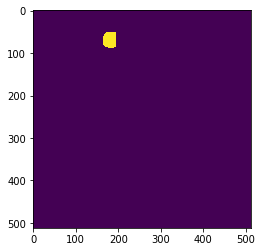

In [36]:
plt.imshow(prediction['masks'][:,:,0])
print(prediction['rois'][0])
print(prediction['scores'][0])

In [37]:
print(np.max(prediction['masks'][:,:,2]))
print(np.max(ag_prediction['masks'][:,:,4]))
print((prediction['masks'][:,:,0].shape[0], prediction['masks'][:,:,0].shape[1], 3))

1
1
(512, 512, 3)


[238 310 263 329]
0.96761596


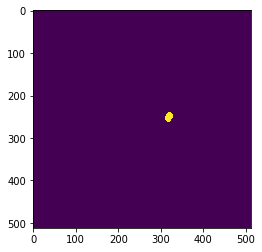

In [38]:
plt.imshow(ag_prediction['masks'][:,:,46])
print(ag_prediction['rois'][46])
print(ag_prediction['scores'][46])

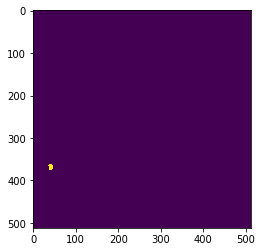

In [39]:
plt.imshow(gt_masks[:,:,45])

In [75]:
i = np.zeros((prediction['masks'][:,:,0].shape[0], prediction['masks'][:,:,0].shape[1], 3), dtype=np.uint8)
diff = np.abs(prediction['masks'][:,:,0] * 255 - ws_prediction['masks'][:,:,0] * 255)
i[:,:,0] = prediction['masks'][:,:,54] * 255
i[:,:,1] = ws_prediction['masks'][:,:,42] * 255
i[:,:,2] = gt_masks[:,:,4] * 255

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
#axarr.imshow(i)
axarr.imshow(i, cmap='jet')

IndexError: index 54 is out of bounds for axis 2 with size 10

In [41]:
new_masks = []

for i, bb_a in enumerate(prediction['rois']):
    for j, bb_b in enumerate(ws_prediction['rois']):
        iou = bbox_iou(bb_a, bb_b)
        if iou >= 0.5 and iou <= 1:
            if prediction['scores'][i] >= 0.9 and ws_prediction['scores'][j] >= 0.9:
                new_masks.append(prediction['masks'][:,:,i] | ws_prediction['masks'][:,:,j])
            elif prediction['scores'][i] >= 0.9:
                new_masks.append(prediction['masks'][:,:,i])
            elif ws_prediction['scores'][j] >= 0.9:
                new_masks.append(ws_prediction['masks'][:,:,j])
            
new_masks = np.asarray(new_masks)
new_masks = np.moveaxis(new_masks, 0, 2)

print('orig AP = {}'.format(dsbhelper.compute_ap(gt_masks, prediction['masks'])))
print('ws   AP = {}'.format(dsbhelper.compute_ap(gt_masks, ws_prediction['masks'])))
print('ens  AP = {}'.format(dsbhelper.compute_ap(gt_masks, new_masks)))

orig AP = 0.45947389719567217
ws   AP = 0.3592927157174162
ens  AP = 0.4824838497403823


In [42]:
new_masks = []

for i, bb_a in enumerate(prediction['rois']):
    for j, bb_b in enumerate(rw_prediction['rois']):
        iou = bbox_iou(bb_a, bb_b)
        if iou >= 0.5 and iou <= 1:
            pix_iou = pixel_iou(prediction['masks'][:,:,i], rw_prediction['masks'][:,:,j])
            if pix_iou >= 0.5 and pix_iou <= 1:
                if prediction['scores'][i] >= 0.9 and rw_prediction['scores'][j] >= 0.9:
                    new_masks.append(prediction['masks'][:,:,i] | rw_prediction['masks'][:,:,j])
                elif prediction['scores'][i] >= 0.9:
                    new_masks.append(prediction['masks'][:,:,i])
                elif rw_prediction['scores'][j] >= 0.9:
                    new_masks.append(rw_prediction['masks'][:,:,j])
            
new_masks = np.asarray(new_masks)
new_masks = np.moveaxis(new_masks, 0, 2)

print('orig AP = {}'.format(dsbhelper.compute_ap(gt_masks, prediction['masks'])))
print('rw   AP = {}'.format(dsbhelper.compute_ap(gt_masks, rw_prediction['masks'])))
print('ens  AP = {}'.format(dsbhelper.compute_ap(gt_masks, new_masks)))

orig AP = 0.45947389719567217
rw   AP = 0.38049649807669483
ens  AP = 0.49319452145301657


In [43]:
new_masks = []

for i, bb_a in enumerate(prediction['rois']):
    for j, bb_b in enumerate(ag_prediction['rois']):
        iou = bbox_iou(bb_a, bb_b)
        if iou >= 0.5 and iou <= 1:
            pix_iou = pixel_iou(prediction['masks'][:,:,i], ag_prediction['masks'][:,:,j])
            if pix_iou >= 0.5 and pix_iou <= 1:
                if prediction['scores'][i] >= 0.9 and ag_prediction['scores'][j] >= 0.9:
                    new_masks.append(prediction['masks'][:,:,i] | ag_prediction['masks'][:,:,j])
                elif prediction['scores'][i] >= 0.9:
                    new_masks.append(prediction['masks'][:,:,i])
                elif ag_prediction['scores'][j] >= 0.9:
                    new_masks.append(ag_prediction['masks'][:,:,j])
            
new_masks = np.asarray(new_masks)
new_masks = np.moveaxis(new_masks, 0, 2)

print('orig AP = {}'.format(dsbhelper.compute_ap(gt_masks, prediction['masks'])))
print('ag   AP = {}'.format(dsbhelper.compute_ap(gt_masks, ag_prediction['masks'])))
print('ens  AP = {}'.format(dsbhelper.compute_ap(gt_masks, new_masks)))

orig AP = 0.45947389719567217
ag   AP = 0.23864065340194474
ens  AP = 0.44122255432738317


In [44]:
new_masks = []

for i, bb_a in enumerate(prediction['rois']):
    for j, bb_b in enumerate(am_prediction['rois']):
        iou = bbox_iou(bb_a, bb_b)
        if iou >= 0.5 and iou <= 1:
            pix_iou = pixel_iou(prediction['masks'][:,:,i], am_prediction['masks'][:,:,j])
            if pix_iou >= 0.5 and pix_iou <= 1:
                if prediction['scores'][i] >= 0.9 and am_prediction['scores'][j] >= 0.9:
                    new_masks.append(prediction['masks'][:,:,i] | am_prediction['masks'][:,:,j])
                elif prediction['scores'][i] >= 0.9:
                    new_masks.append(prediction['masks'][:,:,i])
                elif am_prediction['scores'][j] >= 0.9:
                    new_masks.append(am_prediction['masks'][:,:,j])
            
new_masks = np.asarray(new_masks)
new_masks = np.moveaxis(new_masks, 0, 2)

print('orig AP = {}'.format(dsbhelper.compute_ap(gt_masks, prediction['masks'])))
print('am   AP = {}'.format(dsbhelper.compute_ap(gt_masks, am_prediction['masks'])))
print('ens  AP = {}'.format(dsbhelper.compute_ap(gt_masks, new_masks)))

orig AP = 0.45947389719567217
am   AP = 0.30796974071566346
ens  AP = 0.4501696892942116


In [45]:
# ----------------------------------------------------------------------------------------
# Builds a dict of masks from each of 5 models for a given image and its predictions
# ----------------------------------------------------------------------------------------
def get_mask_lookup(pd, ws, rw, ag, am):    
    
    # there is one roi per mask, this variable is just for readability
    mask_count = pd['rois'].shape[0]

    # create a dictionary with a row for each mask in a prediction set
    mask_lookup = dict()
    mask_lookup['pd'] = np.zeros((mask_count), dtype=np.int8)
    mask_lookup['ws'] = np.zeros((mask_count), dtype=np.int8)
    mask_lookup['rw'] = np.zeros((mask_count), dtype=np.int8)
    mask_lookup['ag'] = np.zeros((mask_count), dtype=np.int8)
    mask_lookup['am'] = np.zeros((mask_count), dtype=np.int8)
    

    # the prediction (pd) element is the base model and is just a sequential list
    for i in range(mask_count):
        mask_lookup['pd'][i] = i

    # find the mask in (watershed) ws for each mask where the bbox iou is >= 0.5
    for i in range(mask_count):
        for j, bbox in enumerate(ws['rois']):
            if bbox_iou(pd['rois'][i], bbox) >= 0.5:
                mask_lookup['ws'][i] = j

    # find the mask in (random walk) rw for each mask where the bbox iou is >= 0.5
    for i in range(mask_count):
        for j, bbox in enumerate(rw['rois']):
            if bbox_iou(pd['rois'][i], bbox) >= 0.5:
                mask_lookup['rw'][i] = j

    # find the mask in (active contours with gaussian blur) ag for each mask where the bbox iou is >= 0.5
    for i in range(mask_count):
        for j, bbox in enumerate(ag['rois']):
            if bbox_iou(pd['rois'][i], bbox) >= 0.5:
                mask_lookup['ag'][i] = j

    # find the mask in (active contours with median blur) am for each mask where the bbox iou is >= 0.5
    for i in range(mask_count):
        for j, bbox in enumerate(am['rois']):
            if bbox_iou(pd['rois'][i], bbox) >= 0.5:
                mask_lookup['am'][i] = j

    return mask_lookup

mask_lookup = get_mask_lookup(prediction, ws_prediction, rw_prediction, ag_prediction, am_prediction)

In [46]:
# 
for i in range(prediction['rois'].shape[0]):
    print('pd:{:02d} -> ws:{:02d}, rw:{:02d}, ag:{:02d}, am:{:02d}'.format(mask_lookup['pd'][i],
                                                                           mask_lookup['ws'][i],
                                                                           mask_lookup['rw'][i],
                                                                           mask_lookup['ag'][i],
                                                                           mask_lookup['am'][i]))

pd:00 -> ws:04, rw:13, ag:25, am:40
pd:01 -> ws:00, rw:00, ag:01, am:21
pd:02 -> ws:05, rw:19, ag:13, am:24
pd:03 -> ws:07, rw:15, ag:24, am:67
pd:04 -> ws:06, rw:02, ag:42, am:15
pd:05 -> ws:03, rw:03, ag:03, am:00
pd:06 -> ws:14, rw:09, ag:06, am:31
pd:07 -> ws:02, rw:08, ag:48, am:30
pd:08 -> ws:26, rw:05, ag:53, am:34
pd:09 -> ws:40, rw:40, ag:17, am:05
pd:10 -> ws:12, rw:18, ag:05, am:23
pd:11 -> ws:13, rw:10, ag:04, am:32
pd:12 -> ws:19, rw:43, ag:23, am:65
pd:13 -> ws:09, rw:04, ag:09, am:18
pd:14 -> ws:16, rw:14, ag:14, am:25
pd:15 -> ws:08, rw:24, ag:21, am:02
pd:16 -> ws:21, rw:11, ag:07, am:19
pd:17 -> ws:20, rw:25, ag:16, am:12
pd:18 -> ws:10, rw:16, ag:41, am:09
pd:19 -> ws:32, rw:62, ag:65, am:54
pd:20 -> ws:29, rw:20, ag:20, am:16
pd:21 -> ws:17, rw:27, ag:12, am:08
pd:22 -> ws:22, rw:21, ag:37, am:53
pd:23 -> ws:01, rw:17, ag:10, am:01
pd:24 -> ws:24, rw:07, ag:39, am:06
pd:25 -> ws:28, rw:34, ag:11, am:45
pd:26 -> ws:18, rw:06, ag:02, am:17
pd:27 -> ws:23, rw:12, ag:00

In [47]:
# ----------------------------------------------------------
# ensembles the masks of 5 models into a final prediction
# ----------------------------------------------------------
def ensemble_masks(pd, ws, rw, ag, am):
    
    # get a mask look up dict
    mask_lookup = get_mask_lookup(pd, ws, rw, ag, am)
    
    # one mask per roi (this is for readability)
    mask_count = pd['rois'].shape[0]
    
    # list to save masks once they have been ensembled
    new_masks = []
    
    # loop through each mask and ensemble them together
    for i in range(mask_count):

        # the pd dictionary contains the base model predictions, begin with that mask
        current_mask = pd['masks'][:,:,i]

        # provided the pixel iou is >= 0.5 and the mask scores are >=0.9, then "or" the masks together
        # do that for each of the models
        if pixel_iou(pd['masks'][:, : ,i], ws['masks'][:, :, mask_lookup['ws'][i]]) >= 0.5:
            if pd['scores'][i] >= 0.9 and ws['scores'][mask_lookup['ws'][i]] >= 0.9:
                current_mask = current_mask | ws_prediction['masks'][:, :, mask_lookup['ws'][i]]

        if pixel_iou(pd['masks'][:, : ,i], rw['masks'][:, :, mask_lookup['rw'][i]]) >= 0.5:
            if pd['scores'][i] >= 0.9 and rw['scores'][mask_lookup['rw'][i]] >= 0.9:
                current_mask = current_mask | rw_prediction['masks'][:, :, mask_lookup['rw'][i]]

        if pixel_iou(pd['masks'][:, : ,i], ag['masks'][:, :, mask_lookup['ag'][i]]) >= 0.5:
            if pd['scores'][i] >= 0.9 and ag['scores'][mask_lookup['ag'][i]] >= 0.9:
                current_mask = current_mask | ag_prediction['masks'][:, :, mask_lookup['ag'][i]]

        if pixel_iou(pd['masks'][:, : ,i], am['masks'][:, :, mask_lookup['am'][i]]) >= 0.5:
            if pd['scores'][i] >= 0.9 and am['scores'][mask_lookup['am'][i]] >= 0.9:
                current_mask = current_mask | am_prediction['masks'][:, :, mask_lookup['am'][i]]

        new_masks.append(current_mask)

    new_masks = np.asarray(new_masks)
    new_masks = np.moveaxis(new_masks, 0, 2)
    
    return new_masks

new_masks = ensemble_masks(prediction, ws_prediction, rw_prediction, ag_prediction, am_prediction)
print('orig AP = {}'.format(dsbhelper.compute_ap(gt_masks, prediction['masks'])))
print('ws   AP = {}'.format(dsbhelper.compute_ap(gt_masks, ws_prediction['masks'])))
print('rw   AP = {}'.format(dsbhelper.compute_ap(gt_masks, rw_prediction['masks'])))
print('ag   AP = {}'.format(dsbhelper.compute_ap(gt_masks, ag_prediction['masks'])))
print('am   AP = {}'.format(dsbhelper.compute_ap(gt_masks, am_prediction['masks'])))
print('ens  AP = {}'.format(dsbhelper.compute_ap(gt_masks, new_masks)))

orig AP = 0.45947389719567217
ws   AP = 0.3592927157174162
rw   AP = 0.38049649807669483
ag   AP = 0.23864065340194474
am   AP = 0.30796974071566346
ens  AP = 0.42482134200283295
